In [17]:
%pip install torch torchvision transformers diffusers datasets accelerate
!unzip dataset.zip

Note: you may need to restart the kernel to use updated packages.


"unzip" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [18]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
import requests
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
discriminator_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
discriminator_model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small")

discriminator_model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),  # Flatten the output
    torch.nn.Linear(768, 256),  # Adjust the input features to match flattened output
    torch.nn.ReLU(),
    #torch.nn.functional.Normalize(),  # Batch normalization layer
    #torch.nn.BatchNorm1d(256),
    #torch.nn.LayerNorm(256),
    torch.nn.Linear(256, 1),
    # torch.nn.Hardtanh()
    torch.nn.Sigmoid()
)


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
teacher_model = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", safety_checker=None, torch_dtype=torch.float16)
teacher_model.scheduler = DPMSolverMultistepScheduler.from_config(teacher_model.scheduler.config)
#teacher_model.safety_checker = lambda image : False

student_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",safety_checker=None, torch_dtype=torch.float16)
student_model.scheduler = DPMSolverMultistepScheduler.from_config(student_model.scheduler.config)

Loading pipeline components...: 100%|██████████| 6/6 [00:16<00:00,  2.71s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [22]:
# Move models to the chosen device

# discriminator_model = discriminator_model.to(device)
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)
print(discriminator_model)


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [23]:
# Set up the loss functions for the student model

# def adversarial_loss_function(y_pred, y_true):
#     return torch.nn.functional.relu(1 - y_pred * y_true)

# def student_loss_function(y_pred, y_true):
#     return - y_pred * y_true

# # Hinge loss for adversarial loss
# adversarial_loss_function.requires_gradient = True

# MSE loss for distillation loss

adversarial_loss_function = torch.nn.BCELoss()

distillation_loss_function = torch.nn.MSELoss()
distillation_loss_function.requires_gradient = True
l = 5

# Set up the optimizer for the student model
student_optimizer = torch.optim.Adam(student_model.unet.parameters(), lr=0.1)

# Assuming you have a discriminator model defined
discriminator_model_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.000001)

In [24]:
# load the train dataset from folder dataset/captions_train2017.json
dataset = load_dataset('json', data_files='dataset/dataset.json')

train_dataset = dataset["train"]

#split the dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
validation_dataset = dataset["test"]

#further split the train dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset)
print(validation_dataset)
print(test_dataset)

torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)


Dataset({
    features: ['caption', 'image'],
    num_rows: 239659
})
Dataset({
    features: ['caption', 'image'],
    num_rows: 29588
})
Dataset({
    features: ['caption', 'image'],
    num_rows: 26629
})


In [25]:
# Function to convert an image from a URL to a PyTorch Tensor
def url_to_tensor(url):

    img = Image.open(requests.get(url, stream=True).raw)

    # Define a transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.Resize((768, 768)),  # Resize the image
        transforms.ToTensor()           # Convert the image to a PyTorch Tensor
    ])

    # Apply the transform to the image
    img_tensor = transform(img)

    return img_tensor

# Get the first image in the training dataset
img_tensor = url_to_tensor(train_dataset[0]['image'])

# Print the shape of the image tensor
print(img_tensor.shape)

torch.Size([3, 768, 768])


In [26]:
def show_tensor_image(pic):

    # Convert the tensor to a PIL Image
    if (isinstance(pic, torch.Tensor)):
        pil_image = transforms.ToPILImage()(pic)

    else:
        pil_image = pic

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

def forward_noise(image, a, s, num_diffusion_steps):

    if (not isinstance(image, torch.Tensor)):
        transform = transforms.ToTensor()
        image = transform(image)

    for i in range(num_diffusion_steps):
        noise = np.random.normal(size=image.shape)  # noise mask
        image = image * a + noise * s

    return image

Epoch 1, Batch Caption: Lap top computer and monitor on a desk with assorted papers and devices.


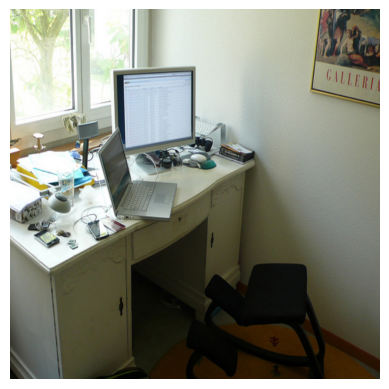

Performing forward diffusion...
Generating student image...


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


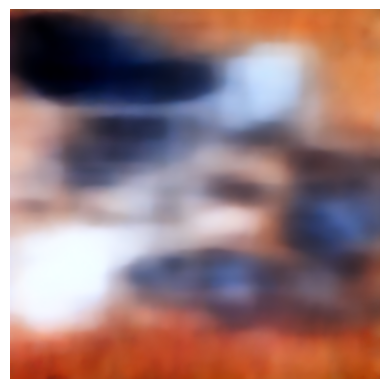

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


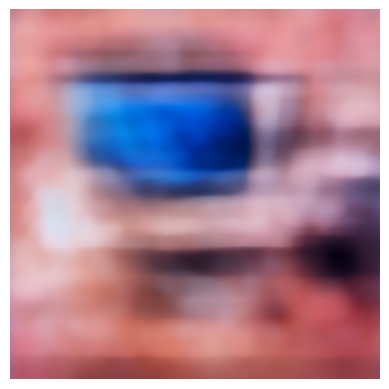

real pred = (tensor([[0.3303]], grad_fn=<SigmoidBackward0>),)
real_pred[0][0][0] = 0.33025839924812317]
Discriminator real Loss: 1.107879877090454
student pred = (tensor([[0.5236]], grad_fn=<SigmoidBackward0>),)
student_pred[0][0][0] = 0.5235984325408936
Discriminator Fake Loss: 0.7414941787719727
Student Loss: 0.647030234336853
Adversarial Loss: 0.9246870279312134
Distillation Loss: 0.0702463686466217
computing the CS score...


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


clip_score = 18.236249923706055
End of batch processing.

Epoch 2, Batch Caption: A fish eye view of part of a bathroom


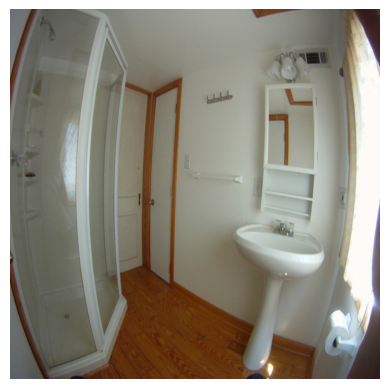

Performing forward diffusion...
Generating student image...


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


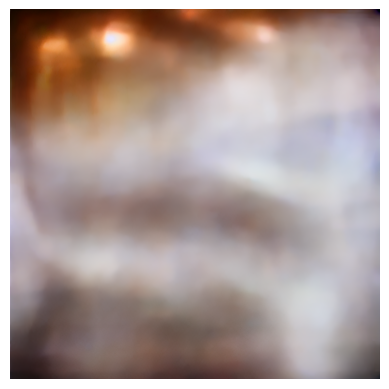

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


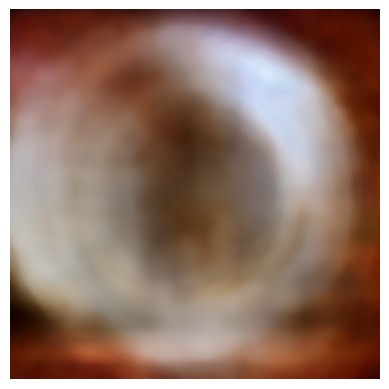

real pred = (tensor([[0.2930]], grad_fn=<SigmoidBackward0>),)
real_pred[0][0][0] = 0.2930172085762024]
Discriminator real Loss: 1.227523922920227
student pred = (tensor([[0.3605]], grad_fn=<SigmoidBackward0>),)
student_pred[0][0][0] = 0.360493540763855
Discriminator Fake Loss: 0.4470585584640503
Student Loss: 1.020281195640564
Adversarial Loss: 0.8372912406921387
Distillation Loss: 0.08338642865419388
computing the CS score...
clip_score = 19.77900505065918
End of batch processing.

Epoch 3, Batch Caption: a plan flying high in the sky on a cloudy day


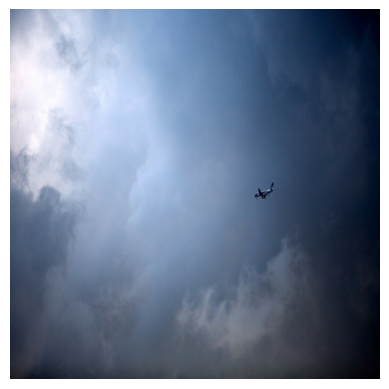

Performing forward diffusion...
Generating student image...


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


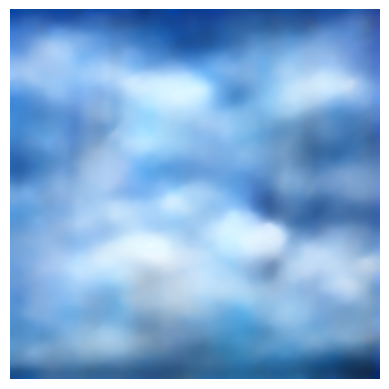

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


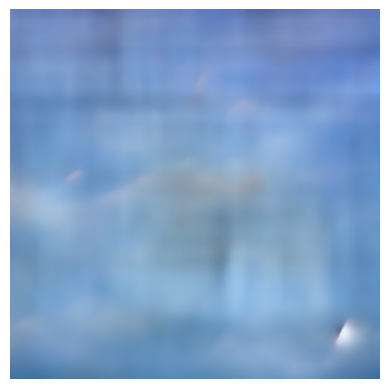

real pred = (tensor([[0.4610]], grad_fn=<SigmoidBackward0>),)
real_pred[0][0][0] = 0.46099144220352173]
Discriminator real Loss: 0.7743757963180542
student pred = (tensor([[0.2669]], grad_fn=<SigmoidBackward0>),)
student_pred[0][0][0] = 0.26688188314437866
Discriminator Fake Loss: 0.31044843792915344
Student Loss: 1.3209490776062012
Adversarial Loss: 0.5424121022224426
Distillation Loss: 0.024382831528782845
computing the CS score...
clip_score = 19.488994598388672
End of batch processing.

Epoch 4, Batch Caption: A man is looking up as a large bird flies overhead.


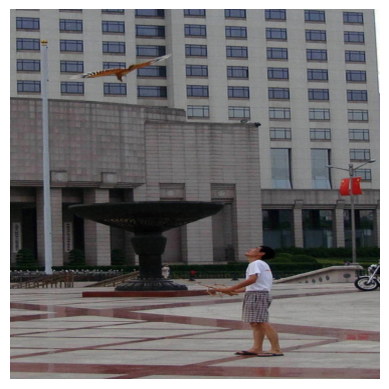

Performing forward diffusion...
Generating student image...


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


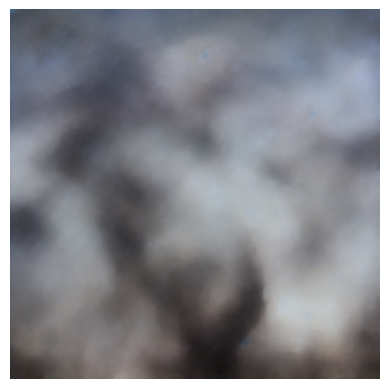

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


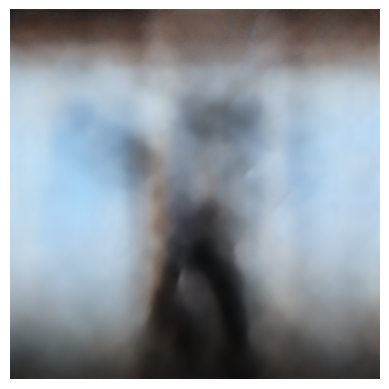

real pred = (tensor([[0.5512]], grad_fn=<SigmoidBackward0>),)
real_pred[0][0][0] = 0.5512025952339172]
Discriminator real Loss: 0.5956528782844543
student pred = (tensor([[0.2232]], grad_fn=<SigmoidBackward0>),)
student_pred[0][0][0] = 0.22316977381706238
Discriminator Fake Loss: 0.2525334656238556
Student Loss: 1.4998224973678589
Adversarial Loss: 0.42409318685531616
Distillation Loss: 0.053548578172922134
computing the CS score...
clip_score = 24.626211166381836
End of batch processing.

Epoch 5, Batch Caption: Busy thumbs type a text message on a mobile phone.


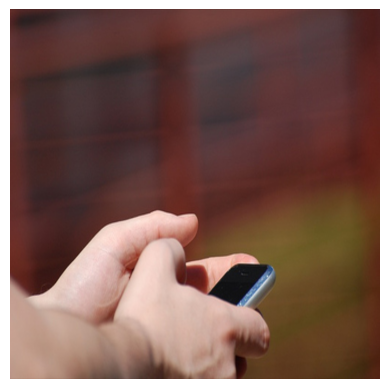

Performing forward diffusion...


KeyboardInterrupt: 

In [29]:
import torch
from torchmetrics.multimodal.clip_score import CLIPScore

CLIPmetric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")


i=0

for batch in train_dataset:

    i+=1

    image = url_to_tensor(batch["image"])
    caption = batch["caption"]

    # Creating labels for real and fake images
    valid = torch.ones(image.size(0), 1)
    fake = torch.zeros(image.size(0), 1)
    real_image = image

    # Displaying the base image and its caption
    print(f"Epoch {i}, Batch Caption: {caption}")
    show_tensor_image(real_image)

    # Forward diffusion step
    print("Performing forward diffusion...")
    diffused_image = forward_noise(image, a=0.5, s=0.5, num_diffusion_steps=50)

    # Transforming images for distillation loss calculation
    transform = transforms.ToTensor()

    # Generating student image
    print("Generating student image...")
    student_image = student_model(caption, image=diffused_image, height=768, width=768, num_inference_steps=4).images[0]
    student_image_tensor = transform(student_image)
    show_tensor_image(student_image_tensor)

    # Forward diffusion on student image
    print("Forward diffusion on student image...")
    new_diffused_image = forward_noise(student_image, a=0.5, s=0.5, num_diffusion_steps=50)

    # Generating teacher image
    print("Generating teacher image...")
    teacher_image = teacher_model(caption, image=new_diffused_image, height=768, width=768, num_inference_steps=100).images[0]
    teacher_image_tensor = transform(teacher_image)
    show_tensor_image(teacher_image_tensor)

    # Discriminator predictions and loss for real image
    real_pred = discriminator_processor(image, return_tensors="pt")
    real_pred = discriminator_model(**real_pred, return_dict=False)

    print(f"real pred = {real_pred}")
    print(f"real_pred[0][0][0] = {real_pred[0][0][0]}]")


    discriminator_real_loss = adversarial_loss_function(real_pred[0][0][0], torch.tensor(1.))

    print(f"Discriminator real Loss: {discriminator_real_loss}")

    # Discriminator predictions and loss for student image
    student_pred = discriminator_processor(student_image, return_tensors="pt")
    student_pred = discriminator_model(**student_pred, return_dict=False)

    print(f"student pred = {student_pred}")
    print(f"student_pred[0][0][0] = {student_pred[0][0][0]}")

    discriminator_fake_loss = adversarial_loss_function(student_pred[0][0][0], torch.tensor(0.))
    
    #student_loss = adversarial_loss_function(student_pred[0][0], torch.tensor(1.))
    student_loss = adversarial_loss_function(student_pred[0][0][0], torch.tensor(1.))

    print(f"Discriminator Fake Loss: {discriminator_fake_loss}")
    print(f"Student Loss: {student_loss}")

    # Calculating adversarial loss
    adversarial_loss = (discriminator_real_loss + discriminator_fake_loss)/2
    print(f"Adversarial Loss: {adversarial_loss}")

    # Computing distillation loss
    distillation_loss = distillation_loss_function(student_image_tensor, teacher_image_tensor)
    distillation_loss.requires_grad = True
    print(f"Distillation Loss: {distillation_loss}")

    #compute the CS score
    print("computing the CS score...")
    clip_score = CLIPmetric(student_image_tensor, caption)
    clip_score.detach()

    print(f"clip_score = {clip_score}")

    # Backpropagation for student model
    student_optimizer.zero_grad()
    #student_loss.backward(retain_graph=True) # Retain graph because student model also needs to backpropagate in this iteration
    #distillation_loss.backward()

    student_total_loss = student_loss + l*distillation_loss

    student_total_loss.backward(retain_graph=True)

    student_optimizer.step()

    # Backpropagation for discriminator model
    discriminator_model_optimizer.zero_grad()
    adversarial_loss.backward()
    discriminator_model_optimizer.step()

    if (i%10 == 0):

        #save the student model and the discriminator model
        print("saving the student model and the discriminator model...")
        student_model.save_pretrained("student_model")
        discriminator_model.save_pretrained("discriminator_model")
        print("...done")

    print("End of batch processing.\n")
